In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import griddata

In order to perform a correct mesh convergence anlaysis, the values for each grid will be compared in this notebook.

# 0. Data adquisition and plotting

In [2]:
_x2 = np.genfromtxt("x2.csv", skip_header=1, delimiter=',')
_x3 = np.genfromtxt("x3.csv", skip_header=1, delimiter=',')
_x  = np.genfromtxt("x.csv", skip_header=1, delimiter=',')
_2x = np.genfromtxt("2x.csv", skip_header=1, delimiter=',')
_3x = np.genfromtxt("3x.csv", skip_header=1, delimiter=',')

dataSets = [_x3, _x2, _x, _2x, _3x]
dataSetsString = ['x3', 'x2', 'x', '2x', '3x']

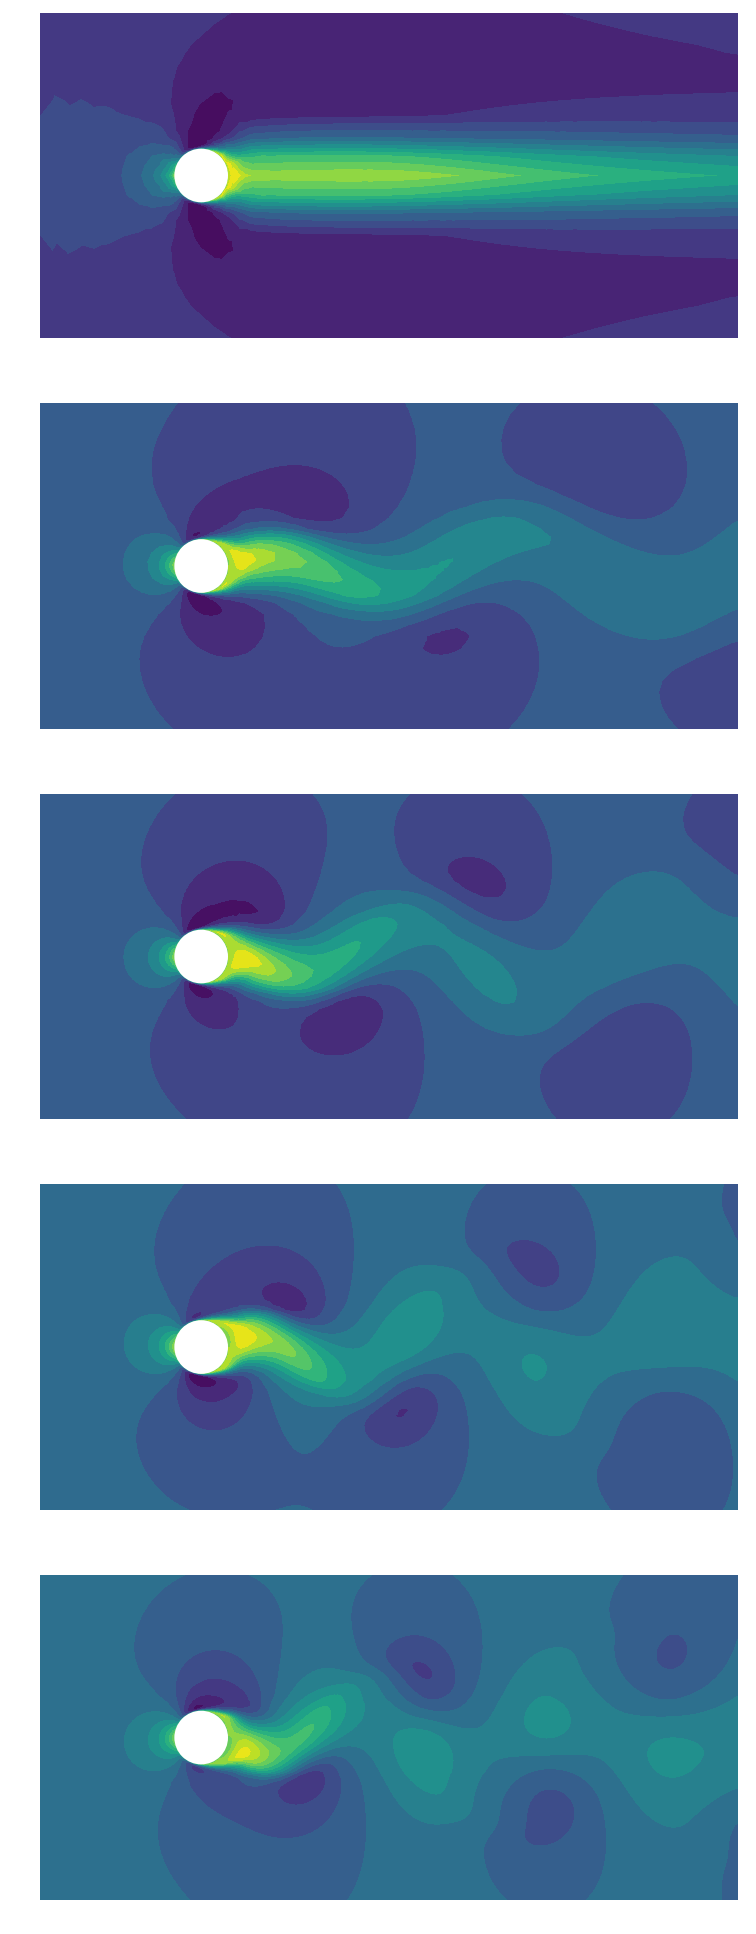

In [4]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(9,25), dpi=100)
axes = [ax1, ax2, ax3, ax4, ax5]

levels = 15

for i in range(len(axes)):
    axes[i].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,1], levels, cmap='viridis_r')
    axes[i].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    axes[i].axis('equal')
    axes[i].axis('off')

# 1. Comparison of field data

There is a problem, the array size is not the same for each case (given that the cells in each case are not the same). In order to approach the case, some grid interpolation will be carried out, having the (interpolated) values of the points of the most refined mesh.

In [5]:
# Objective grid to interpolate (the same for all cases)
xi = np.linspace(-3,10,200)
yi = np.linspace(-5,5,200)
xi, yi = np.meshgrid(xi,yi)

# Interpolation for each case - to have a full array with xi and yi as axis
case = np.zeros((len(dataSets), np.shape(yi)[0], np.shape(yi)[1], 3))
for i in range(len(dataSets)):
    case[i,:,:,0] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,0],(xi,yi),method='linear')
    case[i,:,:,1] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,1],(xi,yi),method='linear')
    case[i,:,:,2] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,2],(xi,yi),method='linear')

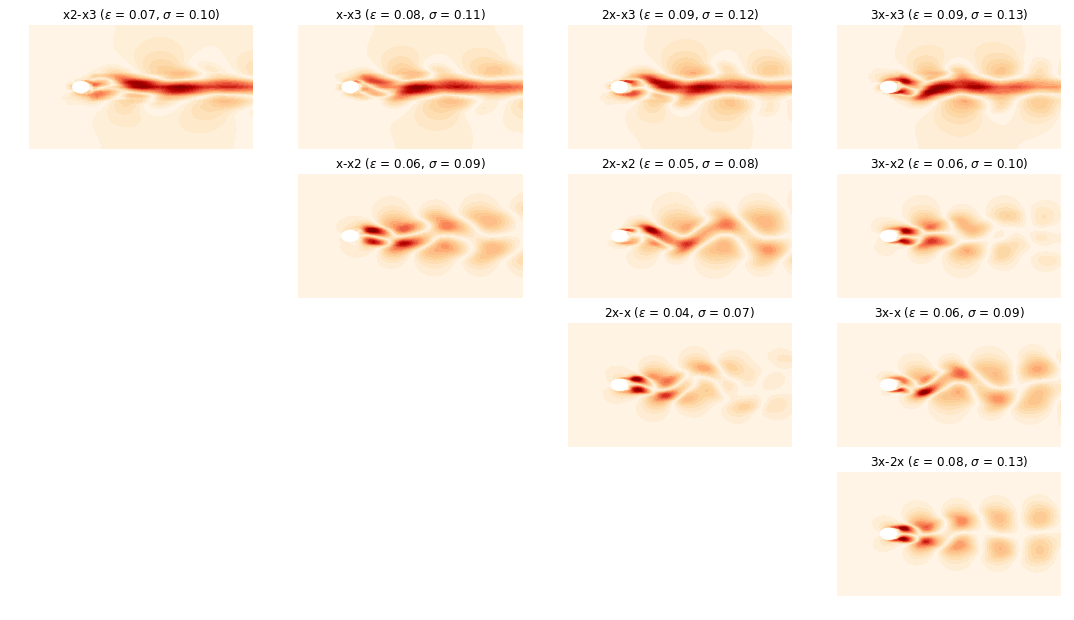

In [74]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(18.5, 10.5)
levels = 20

#Let's make a little space for the same-field comparison plots
ax5.axis('off')
ax9.axis('off')
ax10.axis('off')
ax13.axis('off')
ax14.axis('off')
ax15.axis('off')

realSubplot = [ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax11, ax12, ax16]
comparative = [[1,0],[2,0],[3,0],[4,0],[2,1],[3,1],[4,1],[3,2],[4,2],[4,3]]
mean = np.zeros(len(comparative))
std = np.zeros(len(comparative))

#Let's plot the other cases
for i in range(len(realSubplot)):
    CS = realSubplot[i].contourf(xi, yi, abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]), levels, cmap='OrRd')
    realSubplot[i].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    realSubplot[i].axis('off')
    mean[i]  = np.mean(abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]))
    std[i] = np.std(abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]))
    realSubplot[i].set_title(r'%s-%s ($\varepsilon$ = %.2f, $\sigma$ = %.2f)' %(dataSetsString[comparative[i][0]], dataSetsString[comparative[i][1]], mean[i], std[i]))

# 3. Comparison with mesh properties

In [12]:
nodes = np.array([3350, 14144, 28890, 64684, 114420])
faces = np.array([6415, 27694, 56925, 128084, 227130])
volumes = np.array([1580, 6874, 14160, 31814, 56640])

Are the different mesh parameters related among them?

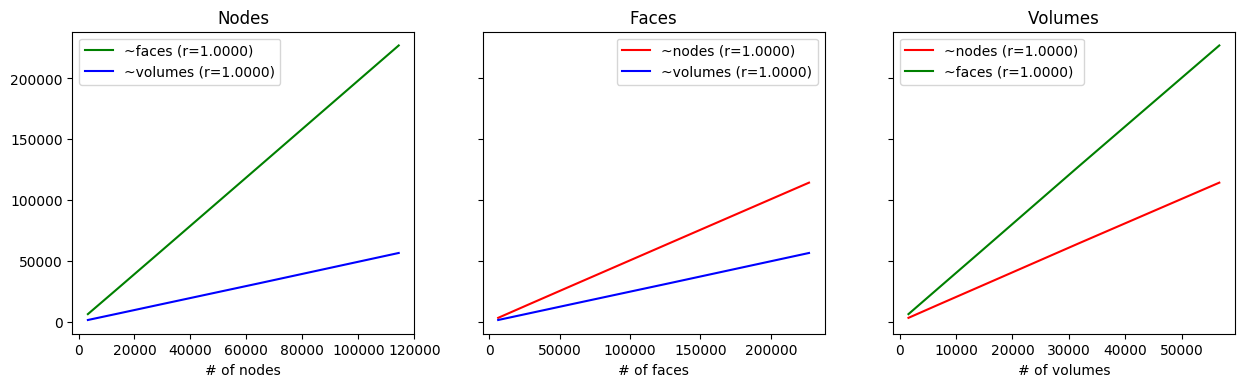

In [53]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4), dpi=100)
ax1.plot(nodes,faces,'g',label='~faces (r=%.4f)' %np.corrcoef(nodes,faces)[1,0])
ax1.plot(nodes,volumes,'b',label='~volumes (r=%.4f)' %np.corrcoef(nodes,volumes)[1,0])
ax1.set_xlabel('# of nodes')
ax1.set_title('Nodes')
ax1.legend()
ax2.plot(faces,nodes,'r',label='~nodes (r=%.4f)' %np.corrcoef(faces, nodes)[1,0])
ax2.plot(faces,volumes,'b',label='~volumes (r=%.4f)' %np.corrcoef(faces, volumes)[1,0])
ax2.set_xlabel('# of faces')
ax2.set_title('Faces')
ax2.legend()
ax3.plot(volumes,nodes,'r',label='~nodes (r=%.4f)' %np.corrcoef(volumes, nodes)[1,0])
ax3.plot(volumes,faces,'g',label='~faces (r=%.4f)' %np.corrcoef(volumes, faces)[1,0])
ax3.set_xlabel('# of volumes')
ax3.set_title('Volumes')
ax3.legend()

All of they are correlated, so no matter which one we choose to analyze mesh convergence. Let's go with nodes

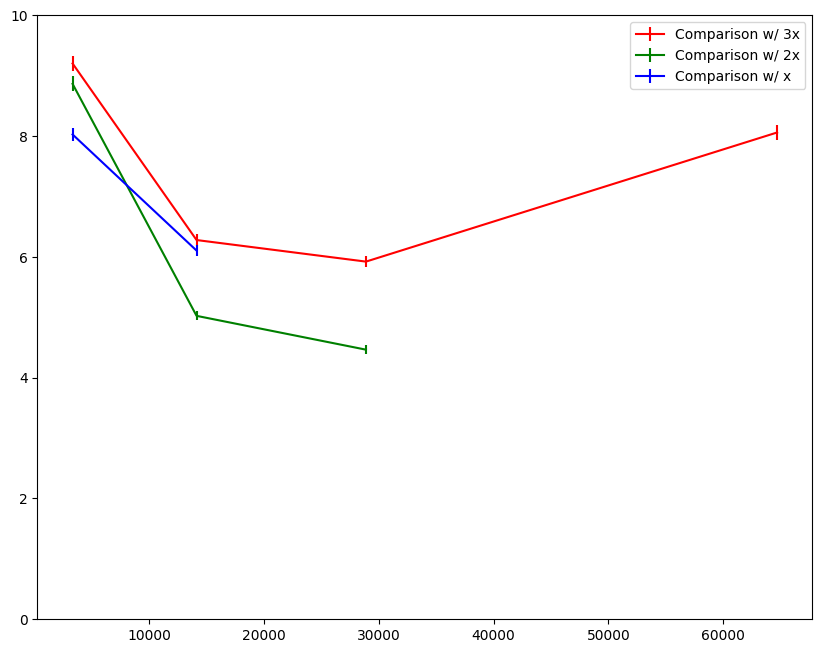

In [86]:
f, (ax1) = plt.subplots(1, figsize=(10,8), dpi=100)
ax1.errorbar(nodes[:-1], 100*mean[[3,6,8,9]], std[[3,6,8,9]], color = 'r', label='Comparison w/ 3x')
ax1.errorbar(nodes[:-2], 100*mean[[2,5,7]], std[[2,5,7]], color = 'g', label='Comparison w/ 2x')
ax1.errorbar(nodes[:-3], 100*mean[[1,4]], std[[1,4]], color = 'b', label='Comparison w/ x')
ax1.set_ylim([0,10])
ax1.legend()